In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [6]:
PATH = "cnnsuperbird/dataset_sb/"

In [7]:
sz=224

In [8]:
!ls {PATH}

train  valid


In [9]:
!ls {PATH}valid

bird  superman


In [10]:
files = !ls {PATH}valid/superman | head
files

['superman.45.jpg',
 'superman.46.jpg',
 'superman.47.jpg',
 'superman.48.jpg',
 'superman.49.jpg',
 'superman.50.jpg',
 'superman.51.jpg',
 'superman.52.jpg',
 'superman.53.jpg',
 'superman.54.jpg']

In [18]:
!ls {PATH}valid/bird | head

bird.100.jpg
bird.101.jpg
bird.102.jpg
bird.103.jpg
bird.104.jpg
bird.105.jpg
bird.106.jpg
bird.107.jpg
bird.108.jpg
bird.109.jpg


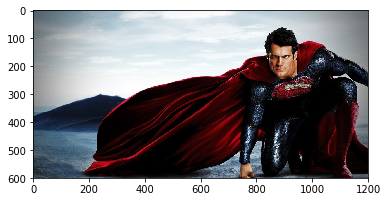

In [16]:
# https://matplotlib.org/users/image_tutorial.html
img = plt.imread(f'{PATH}valid/superman/{files[0]}')
plt.imshow(img);

In [22]:
img.shape

(600, 1200, 3)

In [19]:
img[:4,:4]

array([[[ 57, 130,  57],
        [ 64, 140,  66],
        [ 63, 141,  66],
        [ 48, 130,  54]],

       [[ 69, 142,  71],
        [ 62, 138,  66],
        [ 55, 135,  62],
        [ 50, 134,  57]],

       [[ 67, 142,  73],
        [ 54, 131,  61],
        [ 49, 131,  59],
        [ 56, 140,  65]],

       [[ 36, 112,  47],
        [ 34, 114,  45],
        [ 45, 126,  57],
        [ 59, 142,  70]]], dtype=uint8)

In [20]:
# Uncomment the below if you need to reset your precomputed activations
# !rm -rf {PATH}tmp

In [69]:
bs=5

In [70]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [71]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, bs, tfms)

In [72]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [73]:
learn.unfreeze()

In [110]:
lr=np.array([0.0001,0.001,0.01])

In [111]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/20 [00:00<?, ?it/s, loss=1.68]   


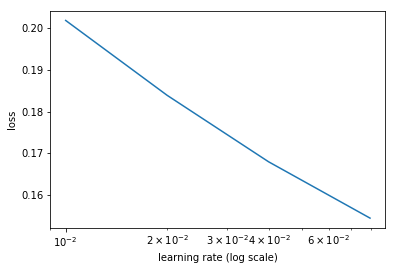

In [112]:
learn.sched.plot()

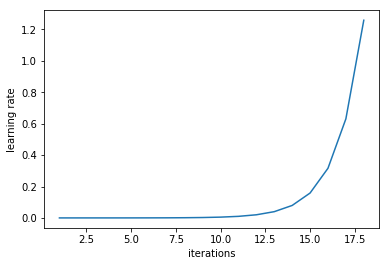

In [103]:
learn.sched.plot_lr()

In [113]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       0.39795  0.03281  0.98   ]             
[ 1.       0.24644  0.03642  0.98   ]             
[ 2.       0.22191  0.02067  0.99   ]             
[ 3.       0.30012  0.01842  0.99   ]             



In [140]:
learn.fit(lr,3,cycle_len=1,cycle_mult=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.57692  0.02272  0.99   ]               
[ 1.       0.27937  0.01528  0.99   ]             
[ 2.       0.30483  0.00572  1.     ]             



In [141]:
learn.save('model')

In [142]:
learn.load('model')

In [143]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [145]:
# from here we know that 'bird' is label 0 and 'superman' is label 1.
data.classes

['bird', 'superman']

In [146]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(98, 2)

In [147]:
log_preds[:10]

array([[ -0.00006,  -9.72527],
       [  0.     , -17.29723],
       [  0.     , -17.29723],
       [ -0.00003, -10.43403],
       [  0.     , -15.53891],
       [ -0.     , -13.55911],
       [ -0.00003, -10.28009],
       [ -0.     , -12.47817],
       [ -0.     , -13.89507],
       [ -0.     , -14.54956]], dtype=float32)

In [148]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])   

In [149]:
def rand_by_mask(mask): 
    return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): 
    return rand_by_mask((preds == data.val_y)==is_correct)

In [150]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [151]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [152]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


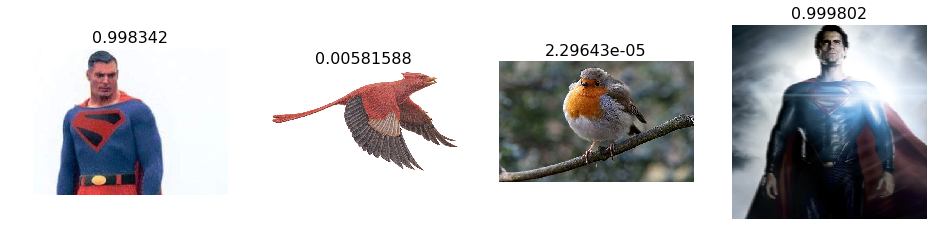

In [167]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [156]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

ValueError: a must be non-empty

In [157]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most correct bird


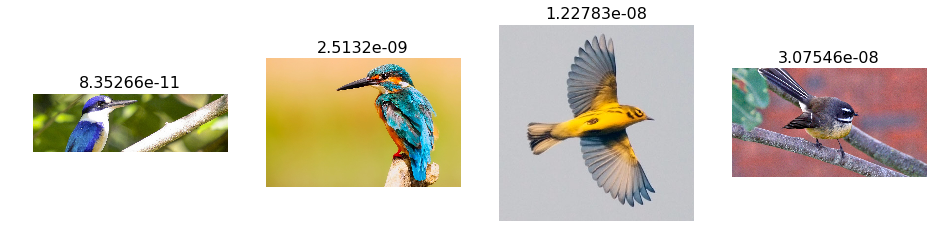

In [159]:
plot_val_with_title(most_by_correct(0, True), "Most correct bird")

Most correct superman


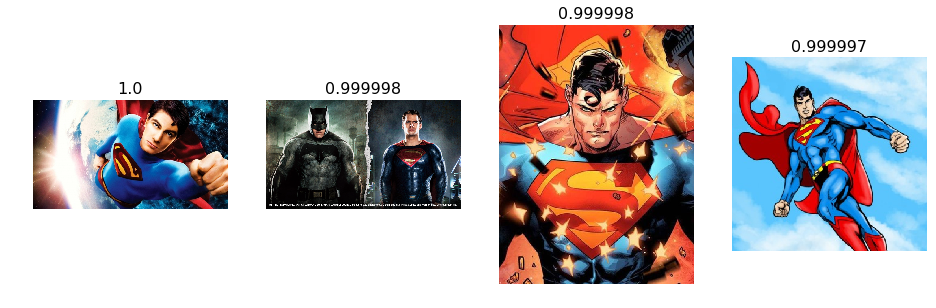

In [160]:
plot_val_with_title(most_by_correct(1, True), "Most correct superman")

In [163]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect bird")

Most incorrect bird


In [164]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect superman")

Most incorrect superman


Most uncertain predictions


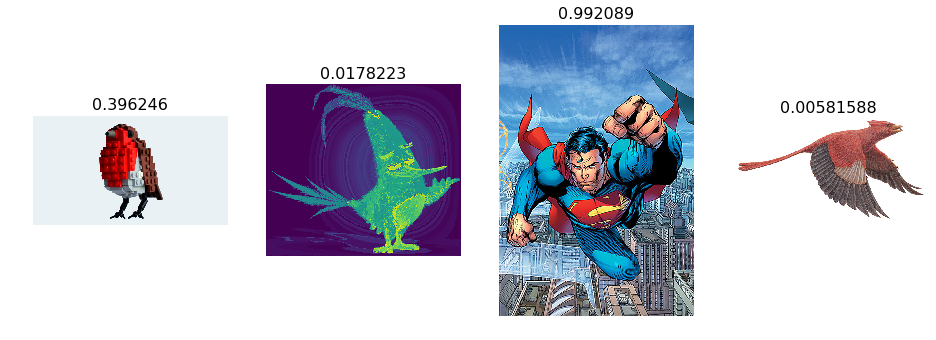

In [166]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")